<a href="https://colab.research.google.com/github/purvasingh96/pytorch-examples/blob/master/Basics/04_Training_an_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training an Image Classifier

## Overview 
We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using `torchvision`
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

## Loading and Normalizing CIFAR10
Using `torchvision` it is easy to load CIFAR10 image dataset. Although, `torchvision` will load image data as PILImage() and hence we need to transform them to `Tensors`.

In [0]:
import torch
import torchvision
from torchvision.transforms import transforms

In [0]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=4, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

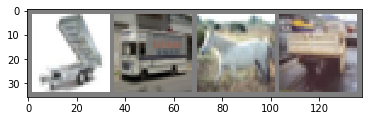

truck truck horse truck


In [11]:
# helper function to display image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
  img = img /2 +0.5
  npimage = img.numpy()
  plt.imshow(np.transpose(npimage, (1, 2, 0)))
  plt.show()

# obtain one batch of training images
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define a Convolutional Neural Network


In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 *5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.pool = nn.MaxPool2d(2, 2)


  def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, self.num_flat_features(x))
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x
    
  def num_flat_features(self, x):
      num_features = 1;
      size = x.size()[1:]
      for features in size:
        num_features *= features
      return num_features

   

In [22]:
net = Net()
print(net)
if(torch.cuda.is_available):
  net.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


## Momentum
A very popular technique that is used along with SGD is called Momentum. Instead of using only the gradient of the current step to guide the search, momentum also accumulates the gradient of the past steps to determine the direction to go

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the Network



In [26]:
for epoch in range(2):
  running_loss = 0.0
  print_every = 2000
  counter = 0
  for images, labels in trainloader:
    if(torch.cuda.is_available):
      images, labels = images.cuda(), labels.cuda()
    counter += 1
    optimizer.zero_grad()
    outputs = net(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if counter % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, counter, running_loss / 2000))
            running_loss = 0.0


[1,  2000] loss: 1.511
[1,  4000] loss: 1.447
[1,  6000] loss: 1.409
[1,  8000] loss: 1.391
[1, 10000] loss: 1.349
[1, 12000] loss: 1.354
[2,  2000] loss: 1.277
[2,  4000] loss: 1.261
[2,  6000] loss: 1.251
[2,  8000] loss: 1.241
[2, 10000] loss: 1.264
[2, 12000] loss: 1.224


In [0]:
path = './cifar10_classifier.pth'
torch.save(net.state_dict(), path)

## Test network on test data

In [49]:
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# class_correct/class_total = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# net.eval()
with torch.no_grad():
  for images, labels in testloader:
    if(torch.cuda.is_available):
      images, labels = images.cuda(), labels.cuda()
    outputs = net(images)
    _, predict = torch.max(outputs,1)
    # predict : tensor([8, 9, 4, 9], device='cuda:0')
    # labels  : tensor([8, 9, 5, 1], device='cuda:0')
    c =  (predict == labels).squeeze()
    # c = tensor([True,  True,  False,  False], device='cuda:0')
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))



Accuracy of plane : 70 %
Accuracy of   car : 61 %
Accuracy of  bird : 32 %
Accuracy of   cat : 34 %
Accuracy of  deer : 55 %
Accuracy of   dog : 50 %
Accuracy of  frog : 79 %
Accuracy of horse : 61 %
Accuracy of  ship : 74 %
Accuracy of truck : 61 %
